В соревновании требуется спрогнозировать цены на недвижимость (аренда квартир) на сервисе airbnb в Лондоне.

Для построения модели доступны следующие данные:

Reviews - резюме отзывов для объявлений об аренде\
Calendar - подробные календарные данные для объявлений об аренде\
Train/Test - описание объявления об аренде.

Для оценки качества модели используется метрика MAPE

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import linear_model

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

reviews =  pd.read_csv("reviews.csv")
calendar = pd.read_csv("calendar.csv")


In [4]:
data_train.head()

,id,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,...,square_feet,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,price
0,127860,Double bedroom in cottage Twickenham (sleeps 1-2),"One gorgeous, light-filled double bedroom (sle...","A beautiful, light-filled double bedroom is ou...","One gorgeous, light-filled double bedroom (sle...",none,"Very, very safe area, great transport links an...",We have a super-gorgeous cat,Twickenham Rugby Stadium is 15 mins walk Water...,"You'll have full use of the cottage, two recep...",...,NaN,300.0,10.0,1,10.0,2,strict_14_with_grace_period,f,f,1000.0
1,325809,Big House for Olympics sleeps 6 to8,NaN,"A beautiful, modern, art-filled and clean 4 st...","A beautiful, modern, art-filled and clean 4 st...",none,NaN,NaN,NaN,NaN,...,1400.0,771.0,NaN,1,0.0,14,strict_14_with_grace_period,f,f,771.0
2,429045,The Old Coach House (Olympics),NaN,"Fabulous, recently refurbished original Victor...","Fabulous, recently refurbished original Victor...",none,NaN,NaN,NaN,NaN,...,1800.0,600.0,NaN,1,0.0,14,strict_14_with_grace_period,f,f,1500.0
3,473637,Brand New contemporary mews house,NaN,Stunning contemporary mews available for let o...,Stunning contemporary mews available for let o...,none,NaN,NaN,NaN,NaN,...,2100.0,300.0,100.0,7,100.0,14,strict_14_with_grace_period,f,f,2000.0
4,533943,LUXURY APT. NEAR BUCKINGHAM PALACE,“The area around Westminster Cathedral has lon...,"This stunning, spacious, 4 bedroom, top floor ...",“The area around Westminster Cathedral has lon...,family,The proximity of all of London's main attracti...,NaN,"Only 5 minutes walk to Victoria Station, the m...",NaN,...,2220.0,2505.0,180.0,1,0.0,14,strict_14_with_grace_period,f,t,901.0


In [5]:
data_train.dtypes

id                                    int64
name                                 object
summary                              object
space                                object
description                          object
experiences_offered                  object
neighborhood_overview                object
notes                                object
transit                              object
access                               object
interaction                          object
house_rules                          object
host_id                               int64
host_since                           object
host_about                           object
host_response_time                   object
host_response_rate                   object
host_is_superhost                    object
host_has_profile_pic                 object
host_identity_verified               object
neighbourhood_cleansed               object
zipcode                              object
latitude                        

<AxesSubplot:>

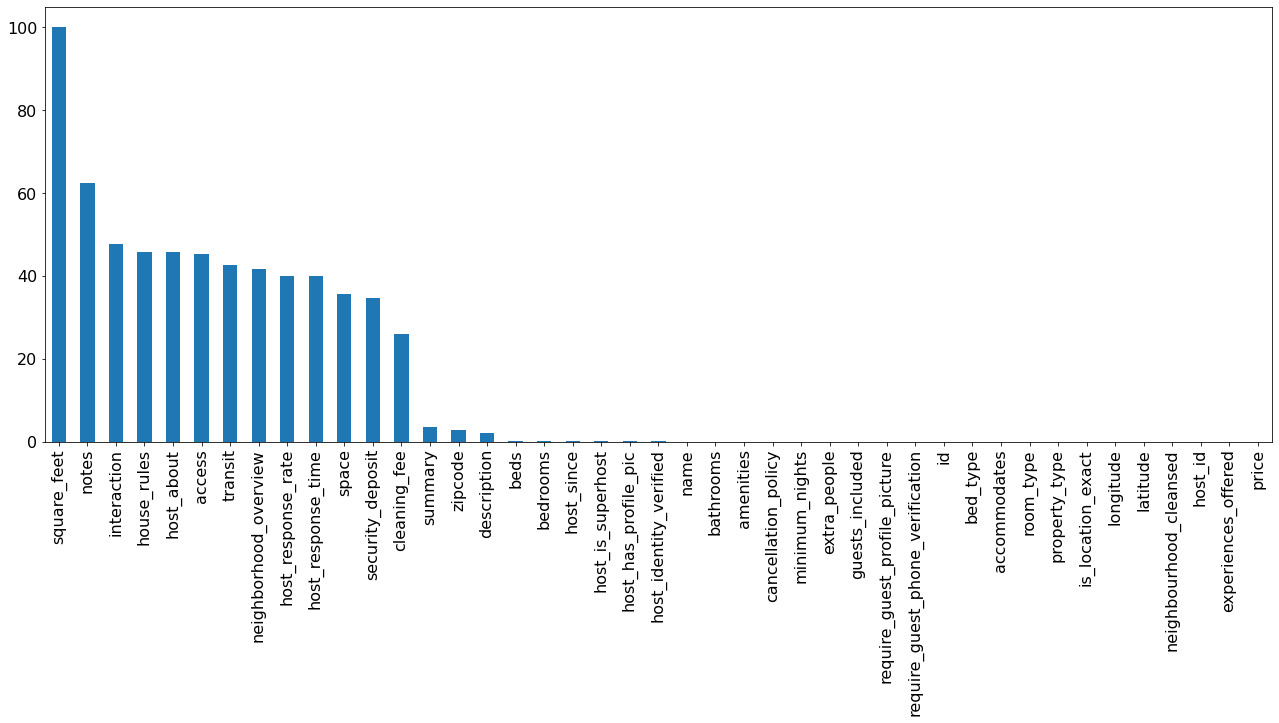

In [6]:
data_train.isnull().sum()
series = data_train.isnull().sum(axis = 0)*100/len(data_train)
series.sort_values(ascending=False).plot(kind = 'bar',fontsize=16,figsize=(22,8))

In [7]:
reviews_count = reviews.groupby('listing_id', as_index=False).count()
reviews_count.drop(['date','reviewer_id','reviewer_name','comments'],axis = 1,inplace = True)
reviews_count.columns = ['id','number_of_reviews']
reviews_count.head()


,id,number_of_reviews
0,9554,133
1,11076,3
2,13913,14
3,17402,39
4,24328,92


<AxesSubplot:>

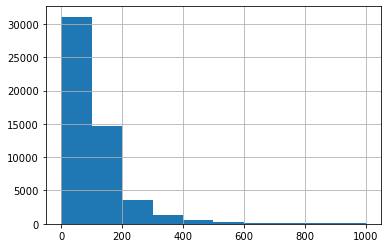

In [8]:
data_train.loc[data_train['price']<1000,'price'].hist()

In [9]:
data_train['price'].describe()

count    51815.000000
mean       115.015787
std        201.599587
min          0.000000
25%         45.000000
50%         80.000000
75%        135.000000
max      13700.000000
Name: price, dtype: float64

In [10]:
calendar.head()

,listing_id,date,available
0,9554,2019-08-18,t
1,97446,2019-11-04,f
2,97446,2019-11-03,f
3,97446,2019-11-02,f
4,97446,2019-11-01,f


In [11]:
calendar['available'] = calendar.available.apply(lambda x: 1 if x == 't' else 0)     
calendar.head()

,listing_id,date,available
0,9554,2019-08-18,1
1,97446,2019-11-04,0
2,97446,2019-11-03,0
3,97446,2019-11-02,0
4,97446,2019-11-01,0


In [12]:
calendar_count = calendar.groupby('listing_id',as_index=False).sum()
calendar_count.columns = ['id','available_rate']
calendar_count['available_rate'] = calendar_count['available_rate']/365
calendar_count.head()

,id,available_rate
0,9554,0.901370
1,11076,0.000000
2,13913,1.000000
3,17402,0.989041
4,24328,0.994521


In [13]:
data_train_merged = pd.merge(data_train, reviews_count, on='id',how='left')
data_test_merged = pd.merge(data_test, reviews_count, on='id',how='left')
data_train_merged = pd.merge(data_train_merged, calendar_count, on='id',how='left')
data_test_merged = pd.merge(data_test_merged, calendar_count, on='id',how='left')

In [14]:
log_price = data_train_merged[data_train_merged['price']<=500]
log_price = log_price.loc[log_price['price']>0,'price']
log_price = np.log(log_price)
log_price.shape

(51090,)

In [15]:
data_train_merged['neighbourhood_cleansed'].unique()

array(['Richmond upon Thames', 'Camden', 'Lewisham',
       'Kensington and Chelsea', 'Westminster', 'Hammersmith and Fulham',
       'Lambeth', 'Southwark', 'Haringey', 'Wandsworth', 'Tower Hamlets',
       'Hackney', 'Barnet', 'Merton', 'Islington', 'Hounslow', 'Newham',
       'Brent', 'Barking and Dagenham', 'Ealing', 'Kingston upon Thames',
       'Sutton', 'Enfield', 'Bexley', 'Hillingdon', 'Greenwich',
       'Waltham Forest', 'Croydon', 'Redbridge', 'City of London',
       'Bromley', 'Harrow', 'Havering'], dtype=object)

In [16]:
def regions(x):
    if x=="Kensington and Chelsea" or x=="Westminster" or x== "City of London":
        x = 190.21
    elif x in ['Camden','Hammersmith and Fulham','Richmond upon Thames','Wandsworth','Islington','Merton']:
        x = 115.02
    elif x in ['Southwark','Tower Hamlets','Lambeth','Hounslow','Hackney','Newham','Brent','Barnet','Haringey','Ealing','Kingston upon Thames',
              'Greenwich']:
        x=85.31
    elif x in [ 'Waltham Forest', 'Havering','Harrow','Hillingdon','Lewisham','Enfield', 'Redbridge','Barking and Dagenham','Bromley',
               'Croydon', 'Sutton', 'Bexley']:
        x=60.47
    return x
    
    
data_test_merged['neighbourhood_cleansed']=data_test_merged['neighbourhood_cleansed'].apply(regions)
data_train_merged['neighbourhood_cleansed']=data_train_merged['neighbourhood_cleansed'].apply(regions)
print(data_train_merged['neighbourhood_cleansed'].unique())

[115.02  60.47 190.21  85.31]


In [17]:
data_train.groupby('cancellation_policy')['price'].mean().sort_values(ascending=False)

cancellation_policy
super_strict_60                373.231579
super_strict_30                230.080972
strict                         150.000000
strict_14_with_grace_period    134.606631
moderate                       103.065660
flexible                        94.301641
Name: price, dtype: float64

In [18]:
data_train_merged.loc[data_train_merged['minimum_nights']>30,'minimum_nights']=30
data_test_merged.loc[data_test_merged['minimum_nights']>30,'minimum_nights']=30

In [19]:
def policy(x):
    if x == 'moderate':
        x = 3
    if x == 'flexible':
        x = 2
    elif x == 'super_strict_30' or x == 'super_strict_60' or x=='strict' or x == 'strict_14_with_grace_period':
        x = 1
    return x

data_test_merged['cancellation_policy']=data_test_merged['cancellation_policy'].apply(policy)
data_train_merged['cancellation_policy']=data_train_merged['cancellation_policy'].apply(policy)


In [20]:
data_train.groupby('room_type')['price'].mean().sort_values(ascending=False)

room_type
Entire home/apt    157.452126
Private room        59.023514
Shared room         41.583333
Name: price, dtype: float64

In [21]:
def room(x):
    if x in ['Shared room']:
        x = 41.58
    elif x == 'Private room':
        x = 59.02
    elif x == "Entire home/apt":
        x = 157.45
    return x

data_test_merged['room_type']=data_test_merged['room_type'].apply(room)
data_train_merged['room_type']=data_train_merged['room_type'].apply(room)
print(data_train_merged['room_type'].unique())

[ 59.02 157.45  41.58]


In [22]:
cols=['id','description','amenities','bed_type','require_guest_profile_picture','require_guest_phone_verification',
     "experiences_offered","name",'host_id',"space","neighborhood_overview",'summary','notes',
      'transit','access','interaction','house_rules','host_since','host_about','host_response_time','host_response_rate',
    'square_feet','zipcode',"host_has_profile_pic",'property_type']
data_test_my_columns = data_test_merged.drop(cols,axis=1)
data_test_my_columns.fillna({'security_deposit':0},inplace=True) 
data_test_my_columns.fillna({'cleaning_fee':0},inplace=True)  
data_test_my_columns.fillna({'host_is_superhost':0},inplace=True)
data_test_my_columns.fillna({'host_identity_verified':0},inplace=True)
data_test_my_columns.fillna({'bathrooms':1},inplace=True)
data_test_my_columns.fillna({'bedrooms':1},inplace=True)
data_test_my_columns.fillna({'beds':1},inplace=True)
data_test_my_columns.fillna({'number_of_reviews':0},inplace=True)
data_test_my_columns = pd.get_dummies(data_test_my_columns, columns=['neighbourhood_cleansed',"room_type",'cancellation_policy'], prefix = ['ng',"rt",'cp'],drop_first=False)
data_test_my_columns['host_identity_verified'] = data_test_my_columns.host_identity_verified.apply(lambda x: 1 if x == 't' else 0)
data_test_my_columns['host_is_superhost'] = data_test_my_columns.host_is_superhost.apply(lambda x: 1 if x == 't' else 0)
data_test_my_columns['is_location_exact'] = data_test_my_columns.is_location_exact.apply(lambda x: 1 if x == 't' else 0)

In [23]:
data_train_my_columns = data_train_merged.drop(cols,axis=1)
data_train_my_columns.fillna({'security_deposit':0},inplace=True) #153
data_train_my_columns.fillna({'cleaning_fee':0},inplace=True)  #30
data_train_my_columns.fillna({'host_is_superhost':0},inplace=True)
data_train_my_columns.fillna({'host_identity_verified':0},inplace=True)
data_train_my_columns.fillna({'bathrooms':1},inplace=True)
data_train_my_columns.fillna({'bedrooms':1},inplace=True)
data_train_my_columns.fillna({'beds':1},inplace=True)
data_train_my_columns.fillna({'number_of_reviews':0},inplace=True)
data_train_my_columns = pd.get_dummies(data_train_my_columns, columns=['neighbourhood_cleansed',"room_type",'cancellation_policy'], prefix = ['ng',"rt",'cp'],drop_first=False)
#data_train_my_columns = pd.get_dummies(data_train_my_columns, columns=['property_type'], prefix = ['pt'],drop_first=True)
data_train_my_columns['host_identity_verified'] = data_train_my_columns.host_identity_verified.apply(lambda x: 1 if x == 't' else 0)
data_train_my_columns['host_is_superhost'] = data_train_my_columns.host_is_superhost.apply(lambda x: 1 if x == 't' else 0)
data_train_my_columns['is_location_exact'] = data_train_my_columns.is_location_exact.apply(lambda x: 1 if x == 't' else 0)

In [24]:
data_train_my_columns= data_train_my_columns[data_train_my_columns['price']>0]
data_train_my_columns= data_train_my_columns[data_train_my_columns['price']<=500]
target = data_train_my_columns['price']
data_train_my_columns = data_train_my_columns.drop(['price'],axis=1)

print(data_test_my_columns.columns)

Index(['host_is_superhost', 'host_identity_verified', 'latitude', 'longitude',
       'is_location_exact', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'number_of_reviews', 'available_rate', 'ng_60.47',
       'ng_85.31', 'ng_115.02', 'ng_190.21', 'rt_41.58', 'rt_59.02',
       'rt_157.45', 'cp_1', 'cp_2', 'cp_3'],
      dtype='object')


In [25]:
data_train_my_columns.head()

,host_is_superhost,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,security_deposit,...,ng_60.47,ng_85.31,ng_115.02,ng_190.21,rt_41.58,rt_59.02,rt_157.45,cp_1,cp_2,cp_3
66,0,0,51.550302,-0.183041,1,2,1.0,3.0,3.0,0.0,...,0,0,1,0,0,0,1,0,1,0
67,1,0,51.541946,-0.103877,1,2,1.0,1.0,1.0,3884.0,...,0,0,1,0,1,0,0,1,0,0
68,0,0,51.541394,-0.061702,1,2,1.0,1.0,1.0,0.0,...,0,1,0,0,0,1,0,0,1,0
69,0,1,51.553531,-0.151746,1,2,1.0,1.0,1.0,0.0,...,0,0,1,0,0,1,0,1,0,0
70,0,1,51.530163,-0.088534,0,2,1.0,1.0,1.0,0.0,...,0,1,0,0,0,1,0,0,0,1


In [26]:
print(data_test_my_columns.shape)
print(data_train_my_columns.shape)
print(log_price.shape)

(23000, 26)
(51090, 26)
(51090,)


In [27]:
from sklearn.preprocessing import  StandardScaler
scaler =  StandardScaler()
data_train_scaled = scaler.fit_transform(data_train_my_columns)
data_test_scaled = scaler.transform(data_test_my_columns)

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
data_train_80,data_test_20,y_train_80,y_test_20 =train_test_split(data_train_scaled, log_price, test_size=0.2,shuffle=True)


In [29]:
ls = linear_model.Lasso()
ls.fit(data_train_80,y_train_80)
y_pred_ls = ls.predict(data_test_20)
print(mean_absolute_percentage_error(y_test_20, y_pred_ls))
print(mean_absolute_error(y_test_20, y_pred_ls))

14.150217331977771
0.590227696373348


In [30]:
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_absolute_error
svr = LinearSVR(max_iter=10000)
svr.fit(data_train_80,y_train_80)

y_pred_svr = svr.predict(data_test_20)
print(mean_absolute_percentage_error(y_test_20, y_pred_svr))
print(mean_absolute_error(y_test_20, y_pred_svr))

7.068333633977152
0.3006869802957795


In [31]:
import lightgbm
model = lightgbm.LGBMRegressor()
model.fit(data_train_80,y_train_80)

y_pred_model = model.predict(data_test_20)
print( mean_absolute_percentage_error(y_test_20, y_pred_model))

5.8025552157255165


In [32]:
from sklearn import model_selection
from sklearn.metrics import  make_scorer
mape = make_scorer(mean_absolute_percentage_error)
gbm_scoring = model_selection.cross_val_score(model,data_train_my_columns,log_price, scoring = 'neg_median_absolute_error', cv = 10)
print(gbm_scoring)
print(gbm_scoring.mean(),gbm_scoring.std())

[-0.19415197 -0.18603569 -0.1832973  -0.1933386  -0.19639893 -0.20625312
 -0.19531083 -0.19087853 -0.18857232 -0.23531326]
-0.1969550551644937 0.014123441917808635


In [33]:
pred_lgm = model.predict(data_test_scaled)
d = [[] for _ in range(len(data_test_my_columns))]
ids = data_test['id'].to_list()
for i in range(len(data_test_my_columns)):
    d[i].append(ids[i])
    d[i].append(np.exp(pred_lgm[i]))
df = pd.DataFrame(d,columns = ['id','price'])
df.head()
df.to_csv("lgbm_prediction.csv",index= False)

In [34]:
(np.exp(pred_lgm).sum())/len(pred_lgm)

85.57105584937244

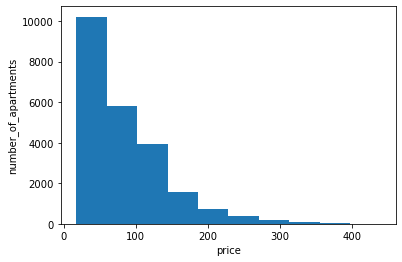

In [35]:
import matplotlib.pyplot as plt
plt.hist(np.exp(pred_lgm))
plt.xlabel('price')
plt.ylabel('number_of_apartments')
plt.show()

Данное решение получило значение метрики 24.87565 в учебном соревновании на kaggle (цель - получить значение ошибки менее 25.05201) и 68 место из 221 участника.